# 2 Markov Chain Monte Carlo


In [1]:
# https://docs.pymc.io/notebooks/GLM-logistic.html

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
from sklearn import preprocessing
from scipy import stats
from scipy import special

# Use a theano shared variable to be able to exchange the data the model runs on
from theano import shared

## 1 Recap
---

\begin{equation}
P(\boldsymbol{\theta}\ |\ D) =  \frac{P(D\ |\ \boldsymbol{\theta})\cdot P(\boldsymbol{\theta})}{P(D)}
\end{equation}

---
### Example
As an introductory example, we observe two weights, 65kg, and 75kg.

We would like to learn something about the distribution of the weights.

![](images/weights.png)

---
How do we model this?

## 1.1 The data

In [3]:
weights = np.array([65, 75])

## 1.2 Parameter space

In [14]:
# lets creat a grid of our two parameters
mu = np.linspace(60, 90)
sigma = np.linspace(0, 10)[::-1]

mm, ss = np.meshgrid(mu, sigma)  # just broadcasted parameters

## 1.3 Likelihood
$$ \prod_{i=0}^N{P(x|\theta)} $$
$$ P(x|\theta) \sim NB(\theta) $$

Text(0, 0.5, '$\\sigma$')

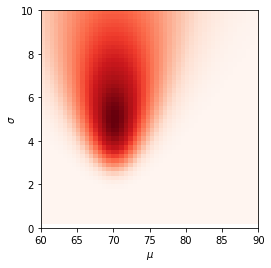

In [22]:
likelihood = stats.norm(mm, ss).pdf(weights[0]) * stats.norm(mm, ss).pdf(weights[1])
aspect = mm.max() / ss.max() / 3
extent = [mm.min(), mm.max(), ss.min(), ss.max()]
# extent = left right bottom top
plt.imshow(likelihood, cmap='Reds', aspect=aspect, extent=extent) 
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

## 1.4 Prior

Text(0, 0.5, '$\\sigma$')

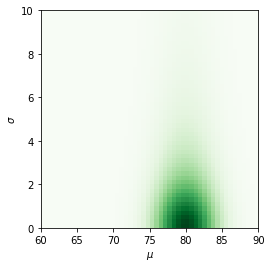

In [24]:
prior = stats.norm(80, 3).pdf(mm) * stats.cauchy(0, 2).pdf(ss)

plt.imshow(prior, cmap='Greens', aspect=aspect, extent=extent)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

## 1.5 Posterior

Text(0, 0.5, '$\\sigma$')

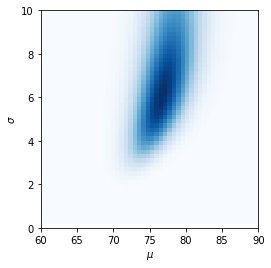

In [31]:
unnormalized_posterior = prior * likelihood
posterior = unnormalized_posterior / np.nan_to_num(unnormalized_posterior).sum()
plt.imshow(posterior, cmap='Blues', aspect=aspect, extent=extent)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

## 1.6 We can do the same with pymc3

In [38]:
weights

array([65, 75])

In [42]:
with pm.Model():
    mu = pm.Normal('mu', mu=80, sd=3)
    sigma = pm.HalfCauchy('sigma', 2)

    observed = pm.Normal('observed', mu=mu, sd=sigma, observed=weights)
    trace = pm.sample(draws=10000, chains=1, step=pm.Metropolis())

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mu]
100%|██████████| 10500/10500 [00:01<00:00, 5297.18it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


/opt/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/opt/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


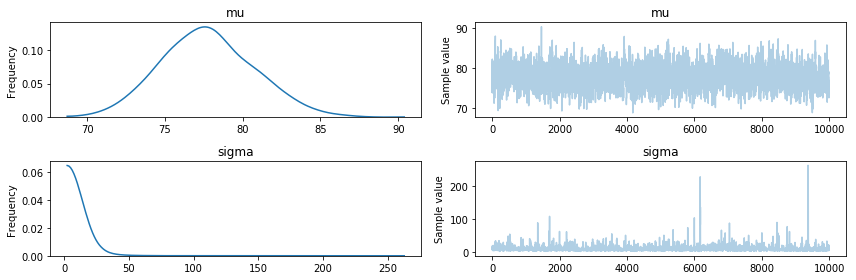

In [43]:
pm.traceplot(trace);

(0, 10.0)

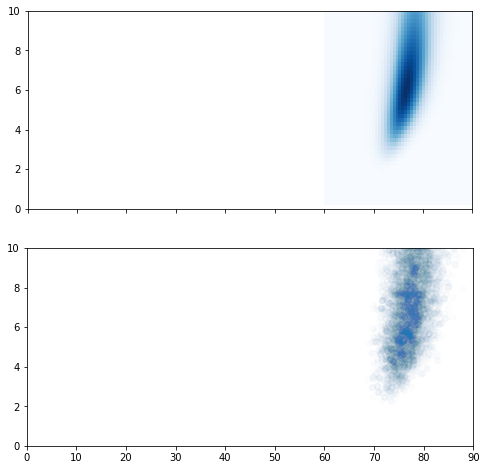

In [50]:
fig, axes = plt.subplots(2, sharex=True, sharey=True, figsize = (8, 8))
axes[0].imshow(posterior, cmap='Blues', extent=extent, aspect=4)
axes[1].scatter(trace['mu'], trace['sigma'], alpha=0.01)
plt.xlim(0, mm.max())
plt.ylim(0, ss.max())

## 1.7 Conclusions

- Posterior is proportional to likelihood multiplied with prior.
- We 'showed' (with plots) that samples obtained with `pymc3` are from this distribution.
- `pymc3` can be used to approximate any posterior, even if we can not validate this with plots or math.

## 2 Intermezzo: Logistic regression 

Let's do a Baysian Logistic regression. What is the chance I'll make \$50k?

First we load and preprocess some data. We use **age, education and working hours** as features $X$ and we try to predict:

$$ y = \begin{cases}
      1, & \text{if income > \$50K}  \\
      0, & \text{otherwise}
    \end{cases}$$

In [259]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", header=None, names=['age', 'workclass', 'fnlwgt',
                'education-categorical', 'educ',
                'marital-status', 'occupation',
                'relationship', 'race', 'sex',
                'captial-gain', 'capital-loss',
                'hours', 'native-country',
                'income'])
data = data[data['native-country'] == ' United-States']
data = data[~pd.isnull(data['income'])]
data = data.assign(more_than_50k=(data['income'] == ' >50K') * 1)
education_map = dict(zip(list(map(lambda x: x.strip(), data['education-categorical'].unique())), data['educ'].unique()))
data = data[['age', 'educ', 'hours', 'more_than_50k']]
data = data.assign(age_squared=data['age']**2)

data.head()

,age,educ,hours,more_than_50k,age_squared
0,39,13,40,0,1521
1,50,13,13,0,2500
2,38,9,40,0,1444
3,53,7,40,0,2809
5,37,14,40,0,1369


Make a correlation table for the features and the labels

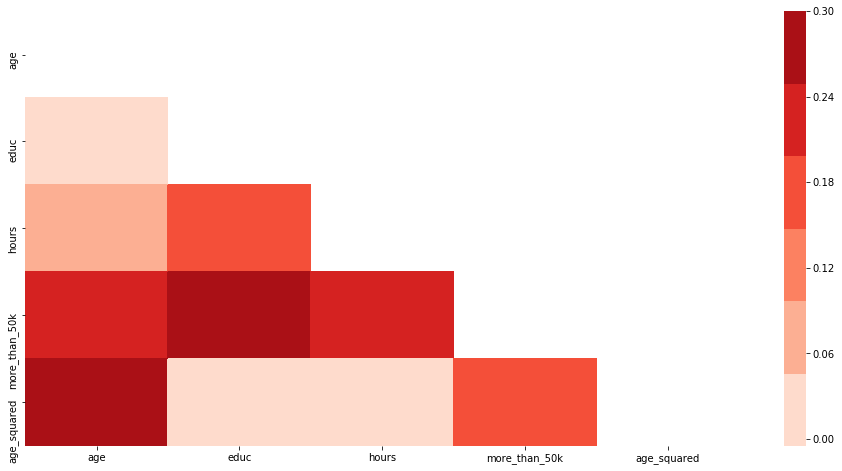

In [35]:
plt.figure(figsize=(16, 8))
corr = data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
# indices for upper triangle of matrix
idx = np.triu_indices_from(corr)
mask[idx] = True
sns.heatmap(corr, mask=mask, vmax=.3, cmap=sns.color_palette('Reds'))

## 2.1 Model
Now we need to think of a model that can explain this data. It's often easiest to start with the labels. The labels are $y \in {0, 1}$. 

## Exercise
* What is a distribution that can generate these labels?
* What is/ are the parameter(s) of this distribution?

## Exercise answers

A Bernoulli distribution represents binary outxomes. The Bernoulli has a parameter $p$, where 

$p = P(x=1)$

* What is the formulation of our model?

Hint: we need a link function $\frac{1}{1 + e^{-z}}$

$$ y \sim Bernoulli(p) $$
$$ p = \frac{1}{1 + e^{-z}} $$
$$ z = \beta X $$

* Now we need to set $P(\theta)$ e.g. priors on $\beta$.

In [237]:
n = 2000
x = data[['age', 'educ', 'hours', 'age_squared']].values[:n]
y = data['more_than_50k'].values[:n]

scaler = preprocessing.MinMaxScaler()
scaled_x = scaler.fit_transform(x)

# add one for intercept
scaled_x = np.hstack((np.ones(x.shape[0])[:, None], scaled_x))
shared_x = shared(scaled_x) # This make it possible to interact date with the Theano computation graph

/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [238]:
shared_x.get_value().max()

1.0

In [239]:
with pm.Model() as model:
    # 3 features and an intercept is 4 dimensions
    beta = pm.Normal('beta', mu=0, sd=15, shape=5)
    observed = pm.Bernoulli('observed', p=pm.math.invlogit(pm.math.dot(beta, shared_x.T)), observed=y)
    

## 2.3 Have we got an uninformative prior?
Below we sample predictions from our posterior. We are uninformative if $P(>50K) \sim 0.5$

In [240]:
with model:
    prior_pc = pm.sample_prior_predictive()

/opt/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


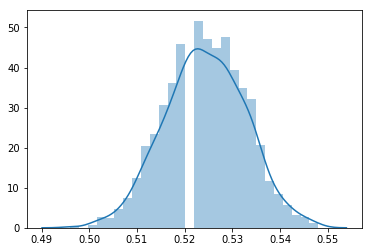

In [241]:
sns.distplot(prior_pc['observed'].mean(0))

In [242]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:22<00:00, 179.48draws/s]


/opt/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7cf13528d0>,
      dtype=object)

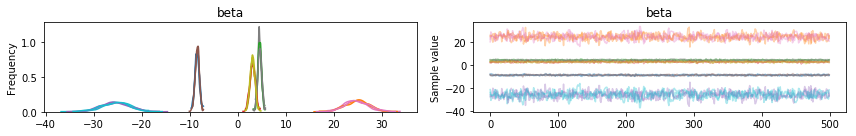

In [243]:
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7cf1296cf8>,
      dtype=object)

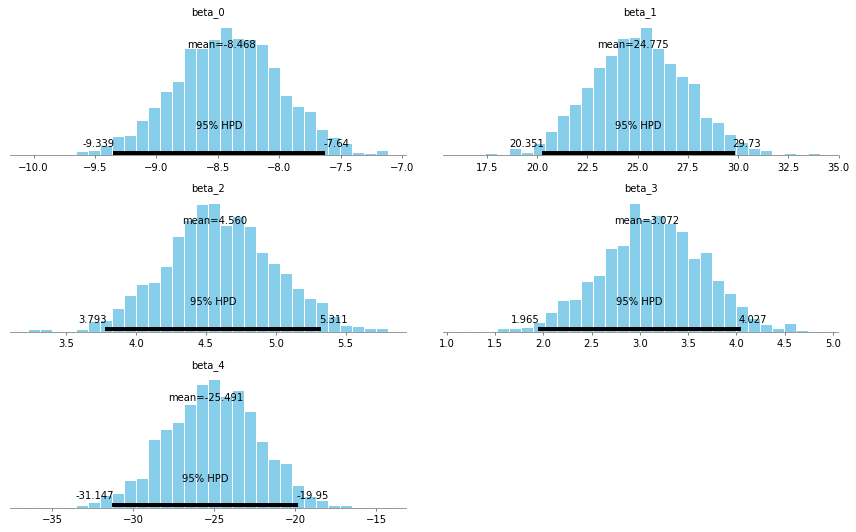

In [244]:
pm.plot_posterior(trace)

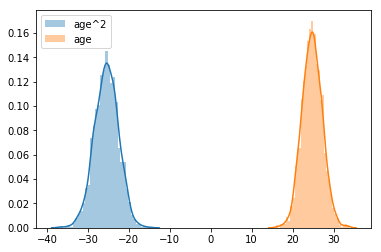

In [247]:
trace_age = trace['beta'][:, 1]
trace_education = trace['beta'][:, 2]
trace_hours = trace['beta'][:, 3]
trace_age_squared = trace['beta'][:, 4]
sns.distplot(trace_age_squared, label='age^2')
sns.distplot(trace_age, label='age')
plt.legend()

## 2.4 Examine the the joint distribution of Betas

Text(336.9714285714286, 0.5, 'beta_hours')

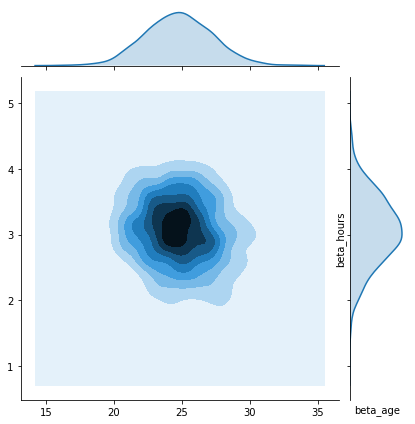

In [246]:
sns.jointplot(trace_age, trace_hours, kind='kde')
plt.xlabel("beta_age")
plt.ylabel("beta_hours")

# and so forth

## 2.3 Posterior Predictive Check
With the posterior predictive check we sample predicitons for our inferred model with the posterior distribution for $\theta$.
Below we make a plot of our probability of making more than 50K. $P(>50K| m)$. Note that this is the probability given our inferred model.

In [248]:
with model:
    ppc = pm.sample_ppc(trace, samples=1000)['observed']
ppc.shape

100%|██████████| 1000/1000 [00:00<00:00, 1209.03it/s]


(1000, 2000)

Text(0.251, 3, 'Average P(>50K)')

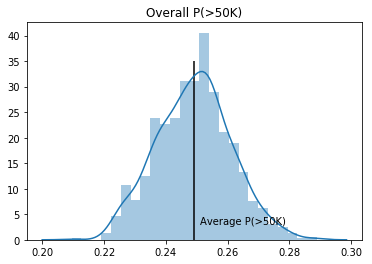

In [249]:
plt.title('Overall P(>50K)')
sns.distplot(ppc.mean(1))
plt.vlines(y.sum() / y.shape[0], 0, 35)
plt.annotate('Average P(>50K)', (y.sum() / y.shape[0] + 0.002, 3))

In [250]:
def prepare_shared_x(col_idx, new_value):
    """
    :param col_idx: (int) 0 = age, 1 = education, 2 = hours
    :param new_value: (flt) Replace the column values with this new value.
    """
    shared_x.set_value(scaled_x)
    feat = np.array(x)
    feat[:, col_idx] = new_value
    if col_idx == 0: # age is also squared
        feat[:, -1] = new_value**2
    feat[:, 1] = 5
    feat = scaler.transform(feat)
    feat = np.hstack((np.ones(feat.shape[0])[:, None], feat))
    shared_x.set_value(feat)
    
prepare_shared_x(0, 20)
shared_x.get_value()

array([[1.        , 0.04109589, 0.26666667, 0.39795918, 0.01421073],
       [1.        , 0.04109589, 0.26666667, 0.12244898, 0.01421073],
       [1.        , 0.04109589, 0.26666667, 0.39795918, 0.01421073],
       ...,
       [1.        , 0.04109589, 0.26666667, 0.29591837, 0.01421073],
       [1.        , 0.04109589, 0.26666667, 0.39795918, 0.01421073],
       [1.        , 0.04109589, 0.26666667, 0.47959184, 0.01421073]])

In [257]:
quants = []
age = np.arange(15, 80, step=5)
with model:
    for a in age:
        prepare_shared_x(0, a)
        ppc = pm.sample_ppc(trace, samples=100, progressbar=False)['observed']
        quants.append(np.quantile(ppc.mean(1), [0.05, 0.5, 0.95]))
quants = np.stack(quants)

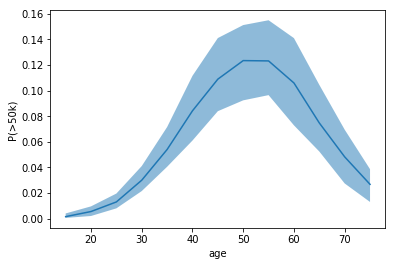

In [258]:
plt.plot(age, quants[:, 1])
plt.ylabel('P(>50k)')
plt.xlabel('age')
plt.fill_between(age, quants[:, 0], quants[:, 2], alpha=0.5)

In [260]:
education_map

{'Bachelors': 13,
 'HS-grad': 9,
 '11th': 7,
 'Masters': 14,
 'Some-college': 10,
 'Assoc-acdm': 12,
 'Doctorate': 16,
 '9th': 5,
 'Assoc-voc': 11,
 '10th': 6,
 '7th-8th': 4,
 'Prof-school': 15,
 '1st-4th': 2,
 'Preschool': 1,
 '5th-6th': 3,
 '12th': 8}

## Exercise

* Make a probability plot hours worked and P(>50K).
* Plot P(>50K) for HS-grad, Bachelors and Masters.

Note, columns are: 0 = age, 1 = education, 2 = hours

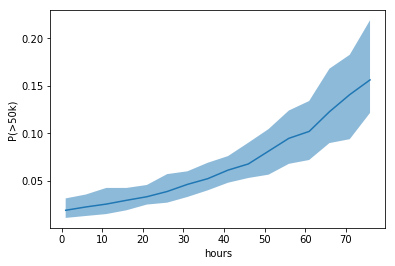

In [253]:
quants = []
age = np.arange(1, 80, step=5)
with model:
    for a in age:
        prepare_shared_x(2, a)
        ppc = pm.sample_ppc(trace, samples=100, progressbar=False)['observed']
        quants.append(np.quantile(ppc.mean(1), [0.05, 0.5, 0.95]))
quants = np.stack(quants)
plt.plot(age, quants[:, 1])
plt.ylabel('P(>50k)')
plt.xlabel('hours')
plt.fill_between(age, quants[:, 0], quants[:, 2], alpha=0.5)

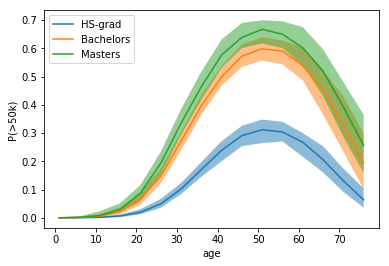

In [262]:
age = np.arange(1, 80, step=5)
with model:
    for education in ['HS-grad', 'Bachelors', 'Masters']:
        quants = []
        for a in age:
            # prepare shared
            shared_x.set_value(scaled_x)
            feat = np.array(x)
            feat[:, 0] = a
            feat[:, -1] = a**2
            feat[:, 1] = education_map[education]
            feat = scaler.transform(feat)
            feat = np.hstack((np.ones(feat.shape[0])[:, None], feat))
            shared_x.set_value(feat)
            ppc = pm.sample_ppc(trace, samples=100, progressbar=False)['observed']
            quants.append(np.quantile(ppc.mean(1), [0.05, 0.5, 0.95]))
            
        quants = np.stack(quants)
        plt.plot(age, quants[:, 1], label=education)
        plt.fill_between(age, quants[:, 0], quants[:, 2], alpha=0.5)
        

plt.ylabel('P(>50k)')
plt.xlabel('age')
plt.legend()


## 3 Markov Chain Monte Carlo [MCMC]

* Markov Chain: A stochastic model describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event.
* Monte Carlo: Probablistic simulation of events with stochastic variables.


Or as I like to put it:

*"
Markov chain Monte Carlo (MCMC) is a technique for estimating by simulation the expectation of a statistic in a complex model. Successive random selections form a Markov chain, the stationary distribution of which is the target distribution. It is particularly useful for the evaluation of posterior distributions in complex Bayesian models. In the Metropolis–Hastings algorithm, items are selected from an arbitrary “proposal” distribution and are retained or not according to an acceptance rule. The Gibbs sampler is a special case in which the proposal distributions are conditional distributions of single components of a vector parameter. Various special cases and applications are considered.
"* (Encyclopedia of Biostatistics)

![](images/donotunderstand.jpg)

## 3.1 King Markov
[statistical rethinking](http://xcelab.net/rm/statistical-rethinking/)
Let's take a look at an analogy to understand what is really going on.

![](images/islands.png)

* King Markov has many islands and amnesia. He doesn't know how many islands he has nor the number of residents living on those islands.
* King Markov wants to visit islands proportional to number of people living on it. For example, with two islands, with distribution `[1, 2]`, spend twice as much time on the second island as one the first.
* He doesn't recognize islands from earlier visits.
* He can only count the current island and one other island.

**GOAL:** 
Find the distribution of number of residents on each island.


## Simple algorithm
* Count the number of inhabitants, stay that amount of day, then move to the next one.


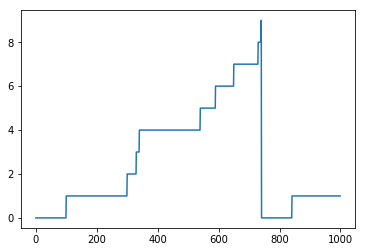

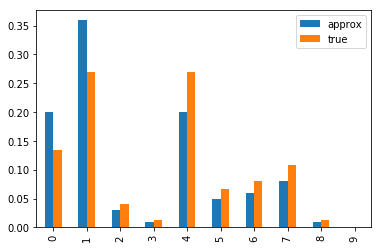

In [92]:
distribution = np.array([100, 200, 30, 10, 200, 50, 60, 80, 10, 1])

def generate_path(distribution, start=0):
    current_position = start
    while True:
        for _ in range(distribution[current_position]):  # stay the number of days
            yield current_position  # return the current island to the distribution stack
        current_position = (current_position + 1) % len(distribution)

gen = generate_path(distribution, 0)

path = np.array([next(gen) for _ in range(1000)])
plt.plot(path)
plt.show()
(pd.Series(path).value_counts(normalize=1)
 .reindex(np.arange(len(distribution)))
 .rename('approx').to_frame()
 .assign(true=distribution / distribution.sum())
).plot.bar()


After 1000 iterations we have visited al the islands, but the approximation is not very good.

Text(0.5, 1.0, 'distribution ratio per island')

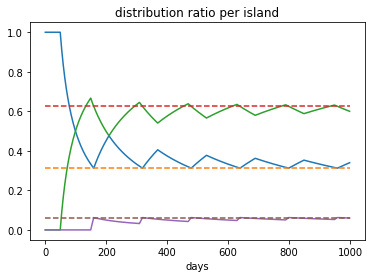

In [150]:
distribution = np.array([50, 100, 10])
gen = generate_path(distribution, 0)

n = 1000
path = np.array([next(gen) for _ in range(n)])

for i in range(len(distribution)):
    # cumulative mean
    plt.plot(np.arange(n), np.cumsum(path == i) / np.arange(1, n + 1), label=f'proportion_{i}')
    plt.plot(np.arange(n), distribution[i] / distribution.sum() * np.ones(n), ls='--', label=f'true_proportion_{i}')

plt.xlabel('days')
plt.title('distribution ratio per island')

In [120]:
(path == 0).sum() / path.shape[0]

0.34